# Importing Libraries

In [0]:
import collections
import math
import os
import errno
import random
import zipfile

In [0]:
import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

# Data URL and Directory to be saved on

In [0]:
data_dir = 'word2vec_data/words'
data_url = 'http://mattmahoney.net/dc/text8.zip'

# Function ot get the data

In [0]:
def fetch_words_data(url=data_url, words_data=data_dir):
  
  os.makedirs(words_data, exist_ok=True)
  zip_path = os.path.join(words_data, 'words.zip')
  
  if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)
    
  with zipfile.ZipFile(zip_path) as f:
    data = f.read(f.namelist()[0])
    
  return data.decode('ascii').split()

# Words in our data

In [0]:
words = fetch_words_data()

In [6]:
len(words)

17005207

In [7]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [8]:
for w in words[9000:9040]:
  print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

# Creating an Numpy array of our data

In [0]:
from collections import Counter

# Function for getting vocabulary and data

In [0]:
def create_counts(vocab_size=50000):
  vocab = [] + Counter(words).most_common(vocab_size)
  vocab = np.array([word for word, _ in vocab])
  dictionary = {word: code for code, word in enumerate(vocab)}
  data = np.array([dictionary.get(word, 0) for word in words])
  return data, vocab

In [0]:
vocab_size = 50000

In [0]:
data, vocabulary = create_counts(vocab_size = vocab_size)

In [13]:
data[0]

5233

In [14]:
(words[100], data[100])

('interpretations', 4186)

In [15]:
vocabulary.shape

(50000,)

In [16]:
vocabulary[np.random.randint(0,50000)]

'semimajor'

# Function for generating batches

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
  span = 2 * skip_window + 1
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    target = skip_window
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span-1)
      targets_to_avoid.append(target)
      batch[i*num_skips+j] = buffer[skip_window]
      labels[i*num_skips+j, 0] = buffer[target]
  if data_index == len(data):
    buffer[:] = data[:span]
    data_index = span
  else:
    buffer.append(data[data_index])
    data_index += 1
    
  data_index = (data_index + len(data)-span)%len(data)
  return batch, labels

In [0]:
data_index = 0

## A single batch

In [0]:
batch, labels = generate_batch(8, 2, 1)

In [20]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080], dtype=int32)

In [21]:
labels

array([[5233],
       [  11],
       [5233],
       [  11],
       [5233],
       [  11],
       [  11],
       [5233]], dtype=int32)

# Hyper-parameters
<ul>
<li>Batch Size
<li>Embedding Size
<li>The Skip Window
<li>Number of skips
<li>Number of Sampled Items
<li>Learning Rate
<li>Vocabulary Size
</ul>

In [0]:
batch_size = 128
embedding_size = 150
skip_window = 1
num_skips = 2

In [0]:
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64
learning_rate = 0.01
vocabulary_size = 50000

In [0]:
tf.reset_default_graph()

# Input Data, Labels & Validation Set

In [0]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Embedding parameter

In [0]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

# Instantiating Embedds

In [0]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# NCE weights & biases

In [0]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# NCE Loss Function

In [0]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

# Adam Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

# Finding Cosine Similarity

In [0]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [0]:
init = tf.global_variables_initializer()

In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.9)

# Training our Model

In [36]:
num_steps = 200001

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
  sess.run(init)
  average_loss = 0
  for step in range(num_steps):
    
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs,  train_labels: batch_labels}
    
    empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
    average_loss += loss_val
    
    if step % 1000 == 0:
      if step > 0:
        average_loss /= 1000
        
      print('Average loss at step ', step, ': ', average_loss)
      
  final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  268.7710266113281
Average loss at step  1000 :  10308.873888717651
Average loss at step  2000 :  22256.48087987016
Average loss at step  3000 :  27200.42739708623
Average loss at step  4000 :  31199.611467253046
Average loss at step  5000 :  34286.032073137176
Average loss at step  6000 :  36373.45043446267
Average loss at step  7000 :  38331.30753944968
Average loss at step  8000 :  45349.006568371
Average loss at step  9000 :  44367.76914542891
Average loss at step  10000 :  45170.83901304573
Average loss at step  11000 :  43999.49737181158
Average loss at step  12000 :  49087.82185930838
Average loss at step  13000 :  45035.30285743806
Average loss at step  14000 :  41605.120631813996
Average loss at step  15000 :  43457.19014055979
Average loss at step  16000 :  45630.989752121764
Average loss at step  17000 :  40566.65384285576
Average loss at step  18000 :  42144.41889029305
Average loss at step  19000 :  42885.108328100505
Average loss at step  20000 :

# Libraries for Plotting

In [0]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

# Function to plot data with labels

In [0]:
def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18,18))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x,y)
    plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points', va='bottom')

In [39]:
type(final_embeddings)

numpy.ndarray

In [40]:
final_embeddings.shape

(50000, 150)

# t-SNE for Dimensionality Reduction

In [0]:
from sklearn.manifold import TSNE

In [0]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [0]:
plot_only = 2000

In [0]:
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

In [0]:
labels = [vocabulary[i] for i in range(plot_only)]

In [48]:
low_dim_embs.shape

(2000, 2)

# 2D data 

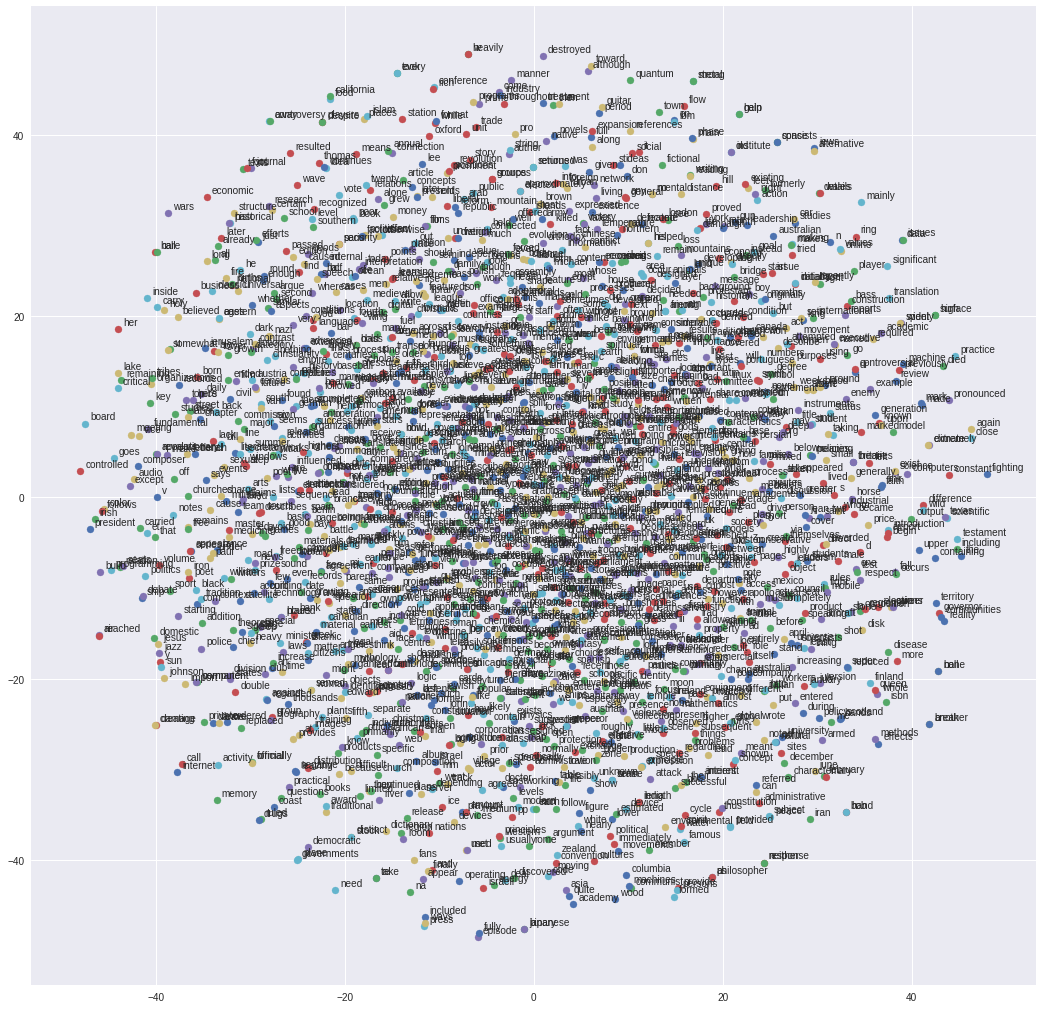

In [50]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

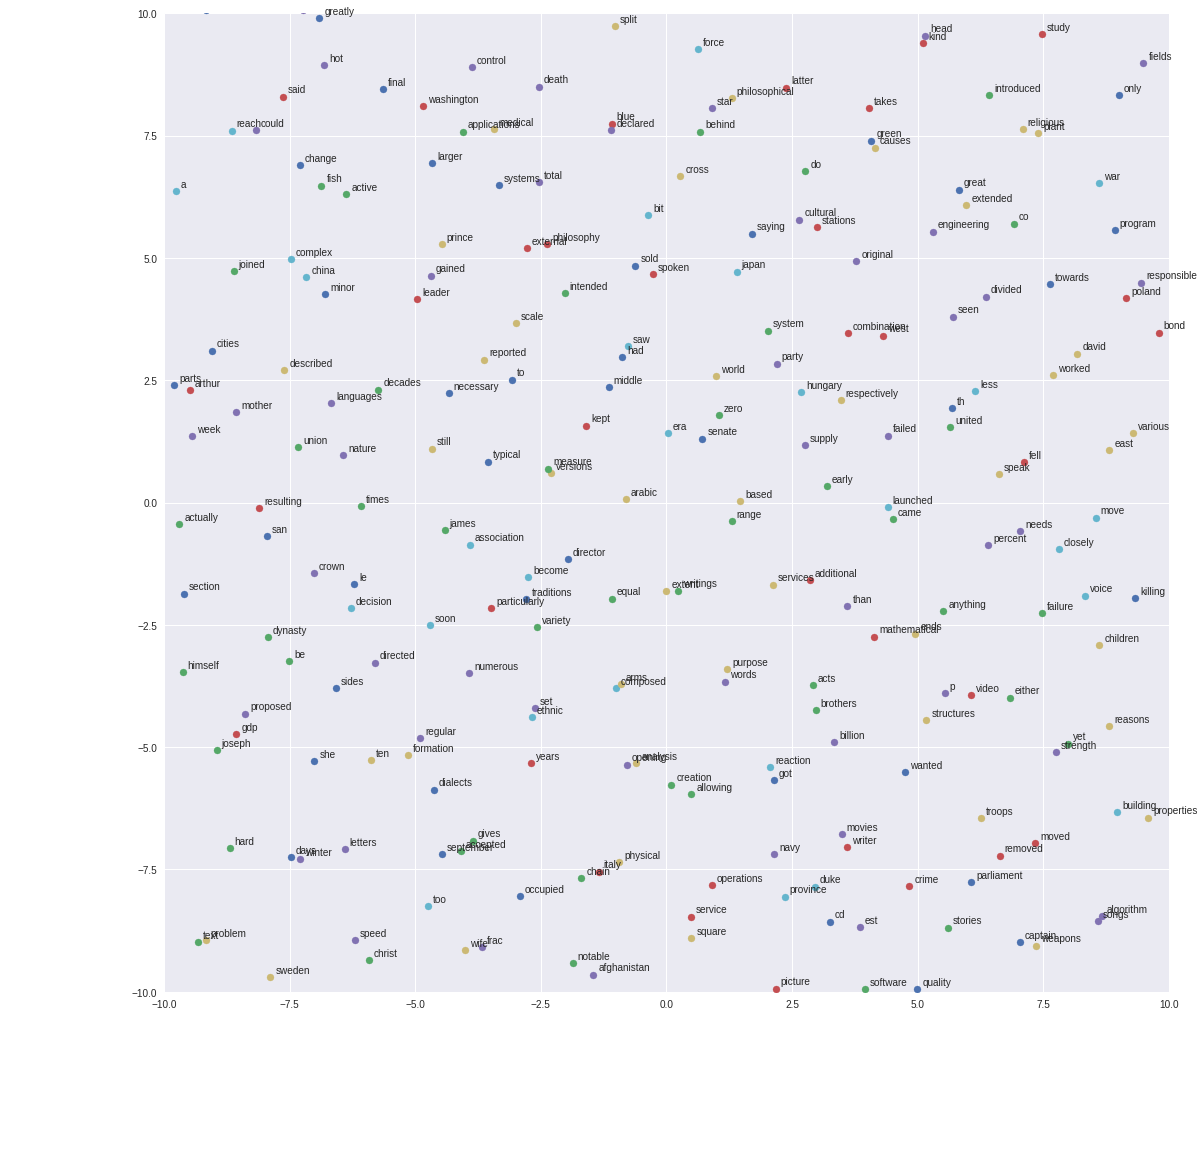

In [51]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

# Saving the model

In [0]:
np.save('trained_embeddings_200k_steps', final_embeddings)

In [54]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 25.8MB/s 


# For Creating a WordCloud

In [0]:
from wordcloud import WordCloud

In [0]:
text = ''
for i in range(len(labels)):
  text += (labels[i] + ' ')

In [59]:
type(text)

str

In [0]:
wordcloud = WordCloud(width=480, height=480, margin=0, background_color='white').generate(text)

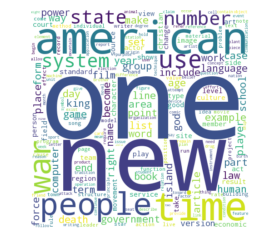

In [68]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

In [70]:
wordcloud.to_file("wordcloud.png")